In [15]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report,roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
os.chdir("/content/drive/MyDrive/Personal/Apziva/YyqSMCLaRZesyT0w")

In [18]:
import feature_plots as fp

##Data Exploration

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

In [6]:
df = pd.read_csv(f"{wd}/term-deposit-marketing-2020.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [7]:
df["default"] = df["default"].map({"yes": 1, "no": 0})
df["housing"] = df["housing"].map({"yes": 1, "no": 0})
df["loan"] = df["loan"].map({"yes": 1, "no": 0})
df["y"] = df["y"].map({"yes": 1, "no": 0})

In [43]:
df.y.value_counts()

,count
y,
no,37104
yes,2896


In [12]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [8]:
def drop_outliers_iqr(df, factor=1.5):
    df_clean = df.copy()
    for col in df_clean.select_dtypes(include=np.number).columns:
        Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - factor*IQR, Q3 + factor*IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

def only_outliers_iqr(df, factor=1.5):
    num_cols = df.select_dtypes(include=np.number).columns
    mask = pd.Series(False, index=df.index)

    for col in num_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - factor*IQR, Q3 + factor*IQR
        out = (df[col] < lower) | (df[col] > upper)
        mask |= out   # mark rows that are outliers in ANY column

    return df[mask]


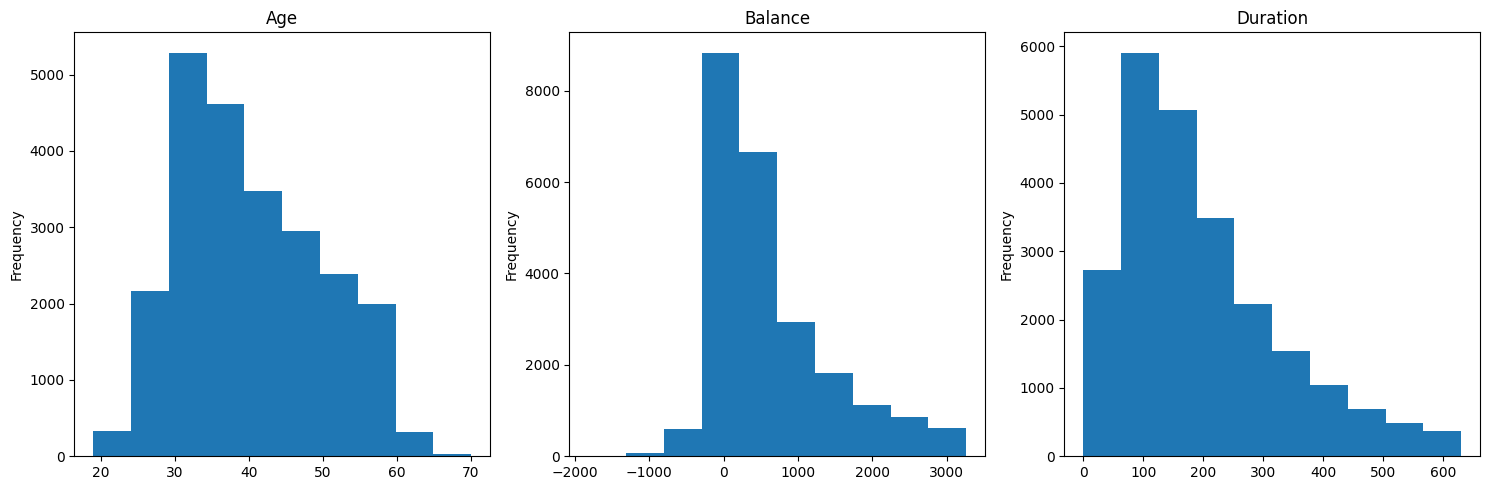

In [9]:
df_noOutliers = drop_outliers_iqr(df)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df_noOutliers.age.plot.hist(ax=axes[0], title="Age")
df_noOutliers.balance.plot.hist(ax=axes[1], title="Balance")
df_noOutliers.duration.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

In [42]:
outliers = only_outliers_iqr(df)
outliers

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
34,51,management,married,tertiary,no,10635,yes,no,unknown,5,may,336,1,no
37,53,technician,married,secondary,no,-3,no,no,unknown,5,may,1666,1,no
43,54,retired,married,secondary,no,529,yes,no,unknown,5,may,1492,1,no
53,42,admin,single,secondary,no,-76,yes,no,unknown,5,may,787,1,no
59,46,services,married,primary,no,179,yes,no,unknown,5,may,1778,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39977,36,unemployed,married,tertiary,no,7222,yes,no,cellular,3,jun,86,1,no
39983,34,management,married,tertiary,no,3402,no,no,cellular,3,jun,88,2,no
39989,51,management,single,tertiary,no,102127,no,no,cellular,3,jun,90,1,no
39991,33,services,single,tertiary,no,1268,yes,no,cellular,3,jun,2219,1,no


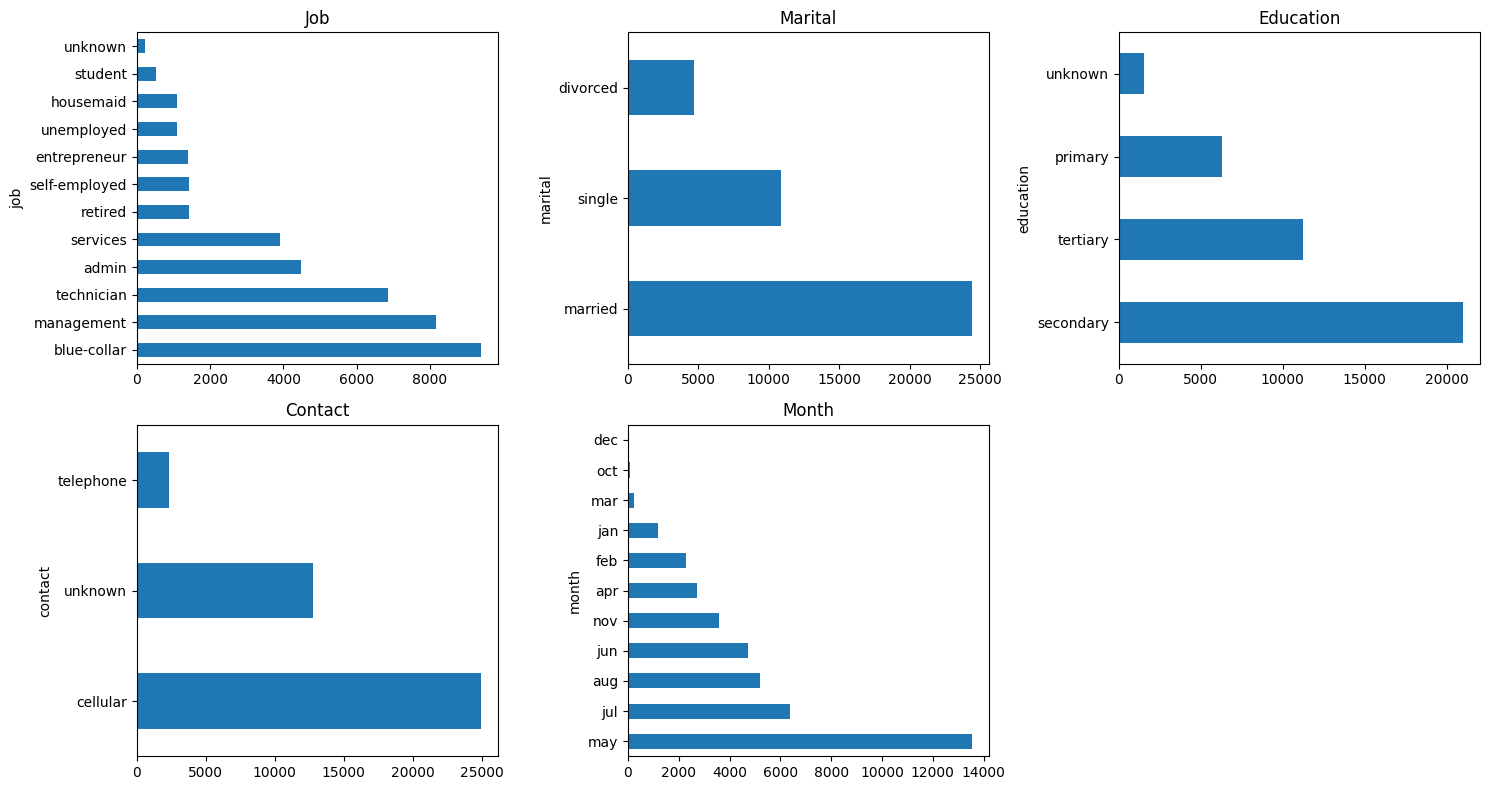

In [21]:
# Make a grid of 2 rows × 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

df.job.value_counts().plot.barh(ax=axes[0], title="Job")
df.marital.value_counts().plot.barh(ax=axes[1], title="Marital")
df.education.value_counts().plot.barh(ax=axes[2], title="Education")
df.contact.value_counts().plot.barh(ax=axes[3], title="Contact")
df.month.value_counts().plot.barh(ax=axes[4], title="Month")

# Hide the unused subplot (6th slot)
axes[5].axis("off")

plt.tight_layout()
plt.show()

###Explore Variable relationships with Y

In [ ]:
# create model instance
bst = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=.1, objective='binary:logistic', num_parallel_tree = 2, subsample = 0.5,reg_lambda=0.5)
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred_train = bst.predict(X_train)
y_preds_test = bst.predict(X_test)

In [ ]:
n_bins = 8
AVG_bin = pd.qcut(df['AVG'], q=n_bins, duplicates='drop')

agg = (df
       .groupby(AVG_bin, observed=True)
       .agg(count=('y','size'), prop_y1=('y','mean'),
            x_mid=('AVG', 'median'))
       .reset_index())

# Plot
fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=(10,4), gridspec_kw={'width_ratios':[2,1]})

# Left plot: counts + proportion
ax_left.bar(agg['x_mid'], agg['count'],
            width=np.diff(np.r_[agg['x_mid'], agg['x_mid'].iloc[-1]]).mean())
ax_left.set_xlabel('AVG (binned, midpoint)')
ax_left.set_ylabel('# of observations')

ax2 = ax_left.twinx()
ax2.plot(agg['x_mid'], agg['prop_y1'], marker='o', color='red')
ax2.set_ylabel('P(Y=1)')
ax2.set_ylim(0,1)
ax_left.set_title('P(Y=1) vs AVG (binned)')

# Right plot: boxplot
sns.boxplot(x='Y', y='AVG', data=df, ax=ax_right)
ax_right.set_title('Distribution of AVG by Y')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_feature_vs_happiness(df,feature,y_col="y", y_pred_col=None,
                              levels=(1, 2, 3, 4, 5),
                              show_boxplot=True,figsize=(10, 4)):
    from matplotlib.ticker import PercentFormatter
    # counts and means (fill missing categories with 0)
    counts = df[feature].value_counts().reindex(levels, fill_value=0)
    obs = df.groupby(feature)[y_col].mean().reindex(levels, fill_value=0.0)

    pred = None
    if y_pred_col and y_pred_col in df.columns:
        pred = df.groupby(feature)[y_pred_col].mean().reindex(levels, fill_value=0.0)

    # figure / axes
    if show_boxplot:
        fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=figsize)
    else:
        fig, ax_left = plt.subplots(figsize=(figsize[0]*0.65, figsize[1]))
        ax_right = None

    # LEFT: bars + one twin axis for both lines
    ax_left.bar(counts.index, counts.values)
    ax_left.set_xlabel(feature)
    ax_left.set_ylabel('# of observations')
    ax_left.set_title(f'{feature} vs. customer satisfaction')

    ax_line = ax_left.twinx()
    ax_line.set_ylabel('Percent Happy')
    ax_line.set_ylim(0, 1)
    ax_line.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    # plot observed (+ optional predicted) with a tiny loop
    handles = []
    for series, label, color in [(obs, 'Observed', 'red'), (pred, 'Predicted', 'yellow')]:
        if series is None:
            continue
        (ln,) = ax_line.plot(series.index, series.values, marker='o', label=label, color=color)
        handles.append(ln)

    if handles:
        ax_line.legend(handles=handles, loc='upper left')

    # RIGHT: optional boxplot
    if show_boxplot:
        sns.boxplot(x=y_col, y=feature, data=df, ax=ax_right)
        ax_right.set_title(f'Distribution of {feature} by {y_col}')
        ax_right.set_xlabel(f'{y_col} (0: Unhappy, 1: Happy)')

    plt.tight_layout()
    return fig, (ax_left, ax_right)
